# HANC

**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [Step 1: Find Steady state](#toc2_)    
  - 2.1. [Idiosyncratic productivity](#toc2_1_)    
  - 2.2. [Policy functions](#toc2_2_)    
  - 2.3. [Simulation](#toc2_3_)    
- 3. [Tests](#toc3_)    
- 4. [Step 2: Compute Jacobians](#toc4_)    
- 5. [Step 3: Find non-linear transition_path](#toc5_)    
- 6. [Decompose household behavior](#toc6_)    
- 7. [Custom shocks](#toc7_)    
  - 7.1. [Path](#toc7_1_)    
  - 7.2. [Initial distribution](#toc7_2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

This notebook shows how to **solve a simple Heterogenous Agent Neo-Classical (HANC) model** using the `GEModelTools` package.

**The steps of the sequence-space solution method are:**

1. Find the stationary equilibrium (steady state for aggregates and distribution).
2. Compute Jacobians of the household block and the full model (to unknowns and shocks)
3. Find the non-linear transition path

In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

from HANCModel import HANCModelClass

## 1. <a id='toc1_'></a>[Setup](#toc0_)

In [2]:
model = HANCModelClass(name='baseline') # create an instance of the model

Show **DAG**:

production_firm: [Gamma,K,L] -> [rK,w,Y]
mutual_fund: [K,rK] -> [A,r]
hh: [r,w] -> [A_hh,C_hh,L_hh]
market_clearing: [A,A_hh,L,L_hh,Y,C_hh,K] -> [I,clearing_A,clearing_L,clearing_Y]


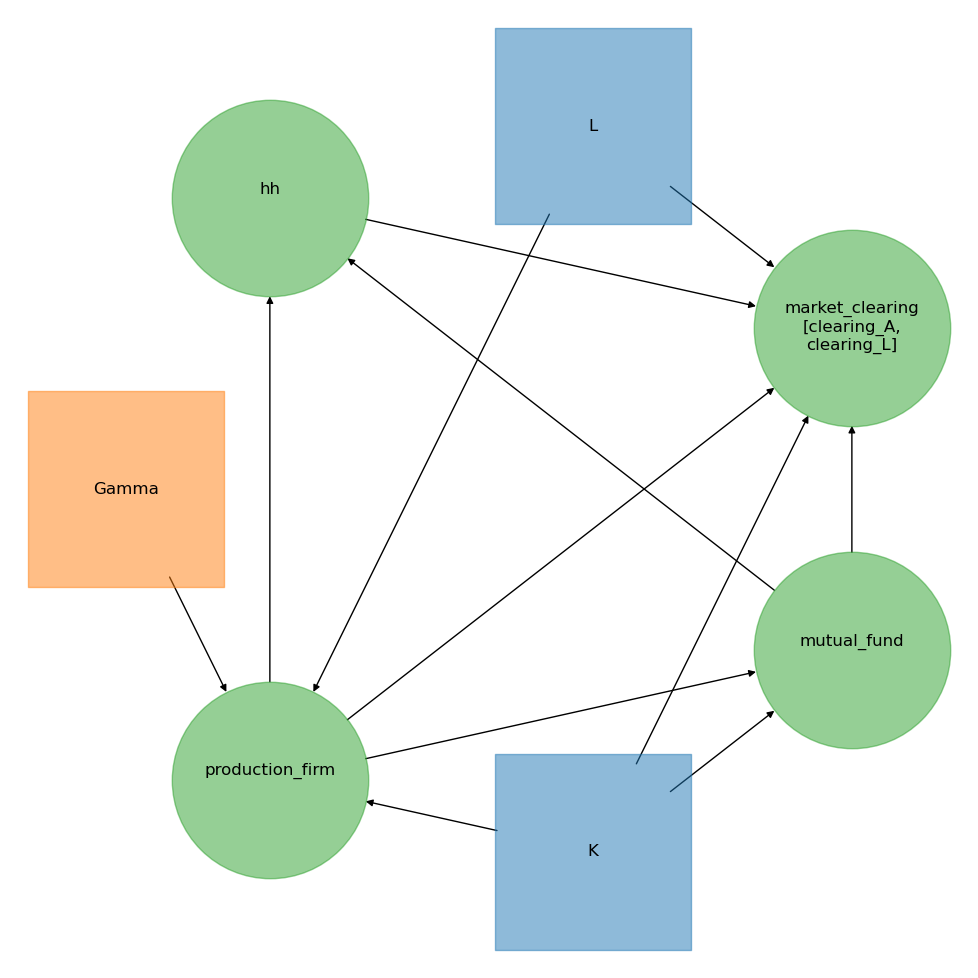

In [3]:
model.info(only_blocks=True)
model.draw_DAG(figsize=(10,10))

Detailed information:

## 2. <a id='toc2_'></a>[Step 1: Find Steady state](#toc0_)

**Task:** We need to find

1. All variables in `.ss`
1. The steady state policy functions `ss.a` and `ss.c`
1. The steady state distributions `ss.Dbeg` and `ss.D`
1. The steady state aggregates `ss.A_hh` and `ss.C_hh`

In `.prepare_hh_ss()` [called in `.solve_hh_ss()` used in `.find_ss()`] we specify:

1. All grids in `.par` (can depend on steady state values prior to the household problem)
1. Initial guess for `ss.Dbeg` when iterating *forwards*
1. Initial guess for `ss.vbeg_a` when iterating *backwards*

In [4]:
model.find_ss(do_print=True,method='indirect')

household problem in ss solved in 6.3 secs [1287 iterations]
household problem in ss simulated in 4.9 secs [1438 iterations]

Implied K =  2.775
Implied Y =  1.562
Implied Gamma =  1.082
Implied delta =  0.193
Implied K/Y =  1.776
Discrepancy in A =   0.00000000
Discrepancy in L =   0.00000000
Discrepancy in Y =   0.00000000
found steady state in 12.1 secs


In [5]:
model.info(only_blocks=True,ss=True)

production_firm: [Gamma=1.08,K=2.78,L=1.00] -> [rK=0.20,w=1.00,Y=1.56]
mutual_fund: [K=2.78,rK=0.20] -> [A=2.78,r=0.01]
hh: [r=0.01,w=1.00] -> [A_hh=2.78,C_hh=1.03,L_hh=1.00]
market_clearing: [A=2.78,A_hh=2.78,L=1.00,L_hh=1.00,Y=1.56,C_hh=1.03,K=2.78] -> [I=0.53,clearing_A=0.00,clearing_L=0.00,clearing_Y=0.00]


**Unpack:** For easy access later on.

In [6]:
par = model.par
ss = model.ss
path = model.path
sim = model.sim

## 3. <a id='toc3_'></a>[Tests](#toc0_)

Here we run a couple of tests to show that the code behaves as expected. This is especially valuable when developing a new model.

**Household transition path:**

note: inputs = steady state value -> expected: constant value (straigt line)

household problem solved along transition path in 0.6 secs
household problem simulated along transition in 1.0 secs



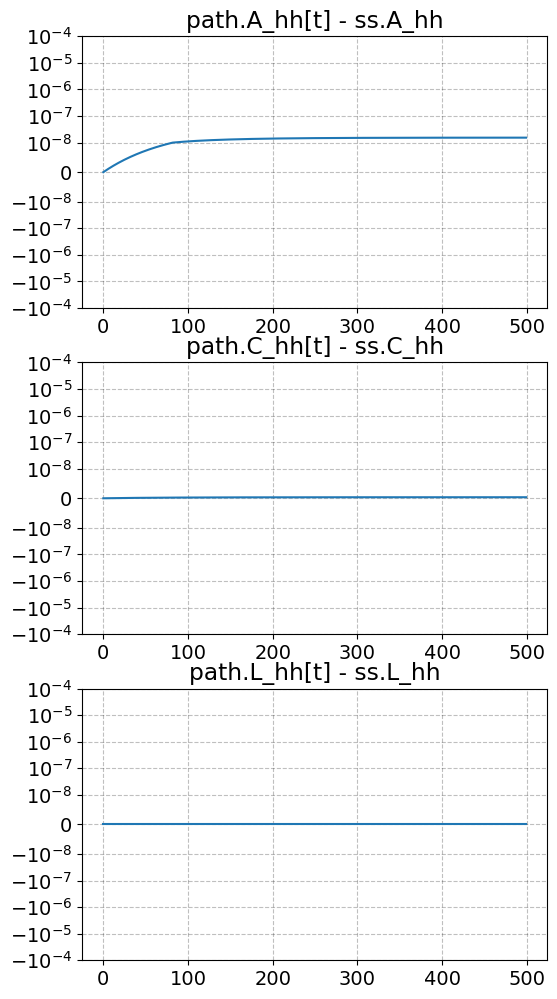

In [7]:
model.test_hh_path()

**Full transition path:**

In [8]:
model.test_path()

shocks: Gamma 
unknowns: K L 

blocks.production_firm
 rK               0.0e+00
 w                0.0e+00
 Y                0.0e+00
blocks.mutual_fund
 A                0.0e+00
 r                8.7e-18
hh
 A_hh             1.5e-08
 C_hh             3.5e-10
 L_hh             2.9e-15
blocks.market_clearing
 I                0.0e+00
 clearing_A       1.5e-08 [target]
 clearing_L       2.0e-14 [target]
 clearing_Y       3.5e-10


## 4. <a id='toc4_'></a>[Step 2: Compute Jacobians](#toc0_)

In [9]:
model.compute_jacs(do_print=True) # if skip_shocks = True the full Jacobians to shocks are  not computed

household Jacobians:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for r               in 0.6 secs
curly_Y and curly_D calculated for w               in 0.6 secs
curly_E calculated in 2.6 secs
builiding blocks combined in 0.2 secs
household Jacobian computed in 4.0 secs

full Jacobians:
full Jacobian to unknowns computed in 0.5 secs [in evaluate_blocks(): 0.2 secs]
full Jacobian to shocks computed in 0.3 secs [in evaluate_blocks(): 0.1 secs]


The Jacobians are saved in:

1. **household Jacobians**: `model.jac_hh` is a dictionary with keys `(Outputname_hh,inputname)`
1. **full Jacobian to *unknowns***: `model.H_U` is a matrix
1. **full Jacobian to *shocks***: `model.H_Z` is a matrix
1. **full Jacobians**: `model.jac` is a dictionary with keys `(outputname,inputname)`

The **household Jacobians** are e.g. informative to look at.

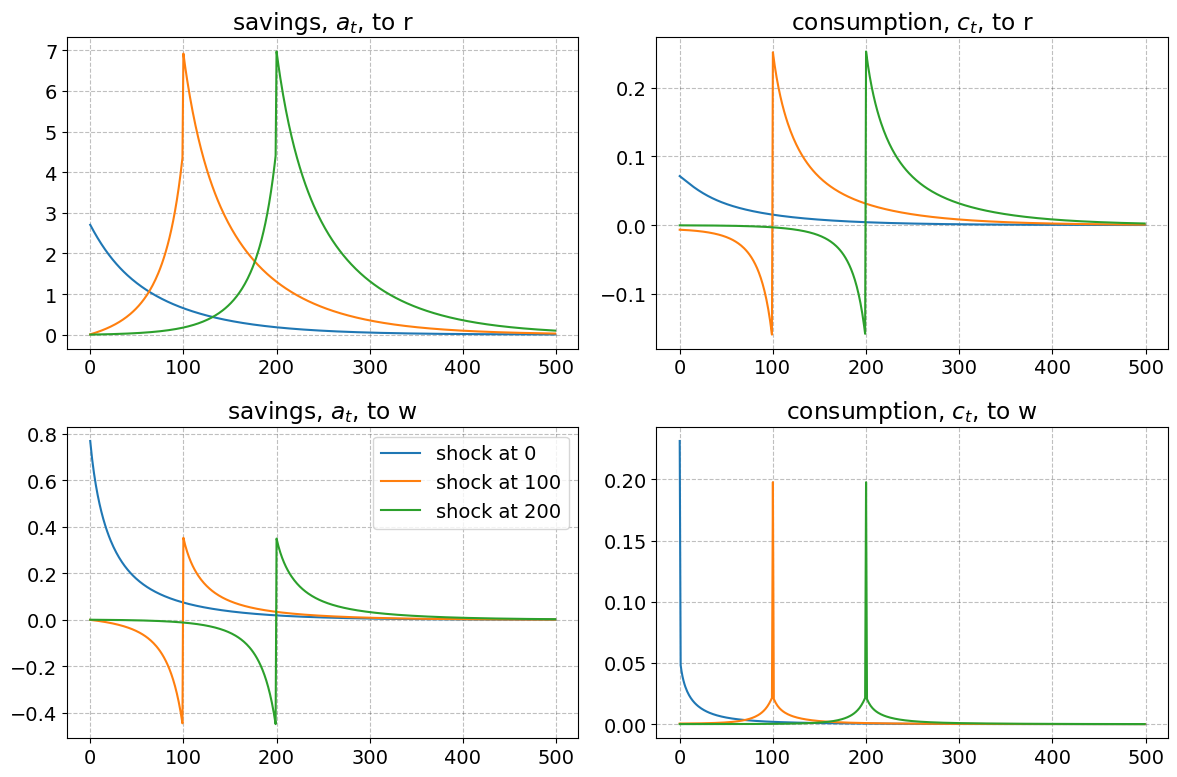

In [10]:
fig = plt.figure(figsize=(12,len(model.inputs_hh_all)*4),dpi=100)

i = 0
for varname in model.inputs_hh:
    
    # a. savings
    i += 1    
    ax = fig.add_subplot(len(model.inputs_hh_all),2,i)
    ax.set_title(f'savings, $a_t$, to {varname}')
    for s in [0,100,200]:
        jac_hh_var = model.jac_hh[('A_hh',varname)]
        ax.plot(np.arange(par.T),jac_hh_var[:,s],label=f'shock at {s}')

    if i == 3: ax.legend(frameon=True)

    # b. consumption
    i += 1    
    ax = fig.add_subplot(len(model.inputs_hh_all),2,i)
    ax.set_title(f'consumption, $c_t$, to {varname}')
    for s in [0,100,200]:
        jac_hh_var = model.jac_hh[('C_hh',varname)]
        ax.plot(np.arange(par.T),jac_hh_var[:,s],label=f'shock at {s}')

fig.tight_layout()
fig.savefig('figs/jac_hh.pdf')

## 5. <a id='toc5_'></a>[Step 3: Find non-linear transition_path](#toc0_)

In [31]:
model.find_transition_path(shocks=['Gamma'],do_print=True)

finding the transition path:
 it =   0 -> max. abs. error = 7.53e-01
   7.53e-01 in clearing_A
   2.51e-14 in clearing_L
 it =   1 -> max. abs. error = 8.27e-02
   8.27e-02 in clearing_A
   9.99e-16 in clearing_L
 it =   2 -> max. abs. error = 9.59e-03
   9.59e-03 in clearing_A
   7.77e-16 in clearing_L
 it =   3 -> max. abs. error = 1.62e-04
   1.62e-04 in clearing_A
   4.44e-16 in clearing_L
 it =   4 -> max. abs. error = 8.25e-06
   8.25e-06 in clearing_A
   4.44e-16 in clearing_L
 it =   5 -> max. abs. error = 9.17e-08
   9.17e-08 in clearing_A
   5.55e-16 in clearing_L
 it =   6 -> max. abs. error = 1.21e-10
   1.21e-10 in clearing_A
   5.55e-16 in clearing_L
 it =   7 -> max. abs. error = 2.54e-12
   2.54e-12 in clearing_A
   6.66e-16 in clearing_L

transition path found in 8.9 secs


**Results:** We now have

1. The transition path of all variables, `path.VARNAME.shape == (par.T,1)`
1. The transition path of policy functions, `path.a` and `path.c`
1. The transition path of distributions, `path.D`

The **timing** is such that `path.A_hh[t] == np.sum(path.a[t]*path.D[t])`.

In [32]:
diff = path.A_hh-np.sum(path.a*path.D,axis=(1,2,3))[:,np.newaxis]
max_abs_diff = np.max(np.abs(diff))
print(f'{max_abs_diff = }')

max_abs_diff = 0.0


**Plot transitions**

### shocks ###


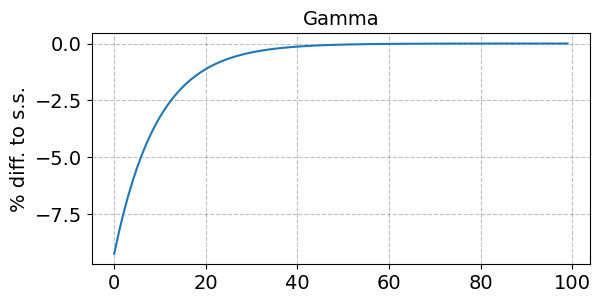


### varnames ###


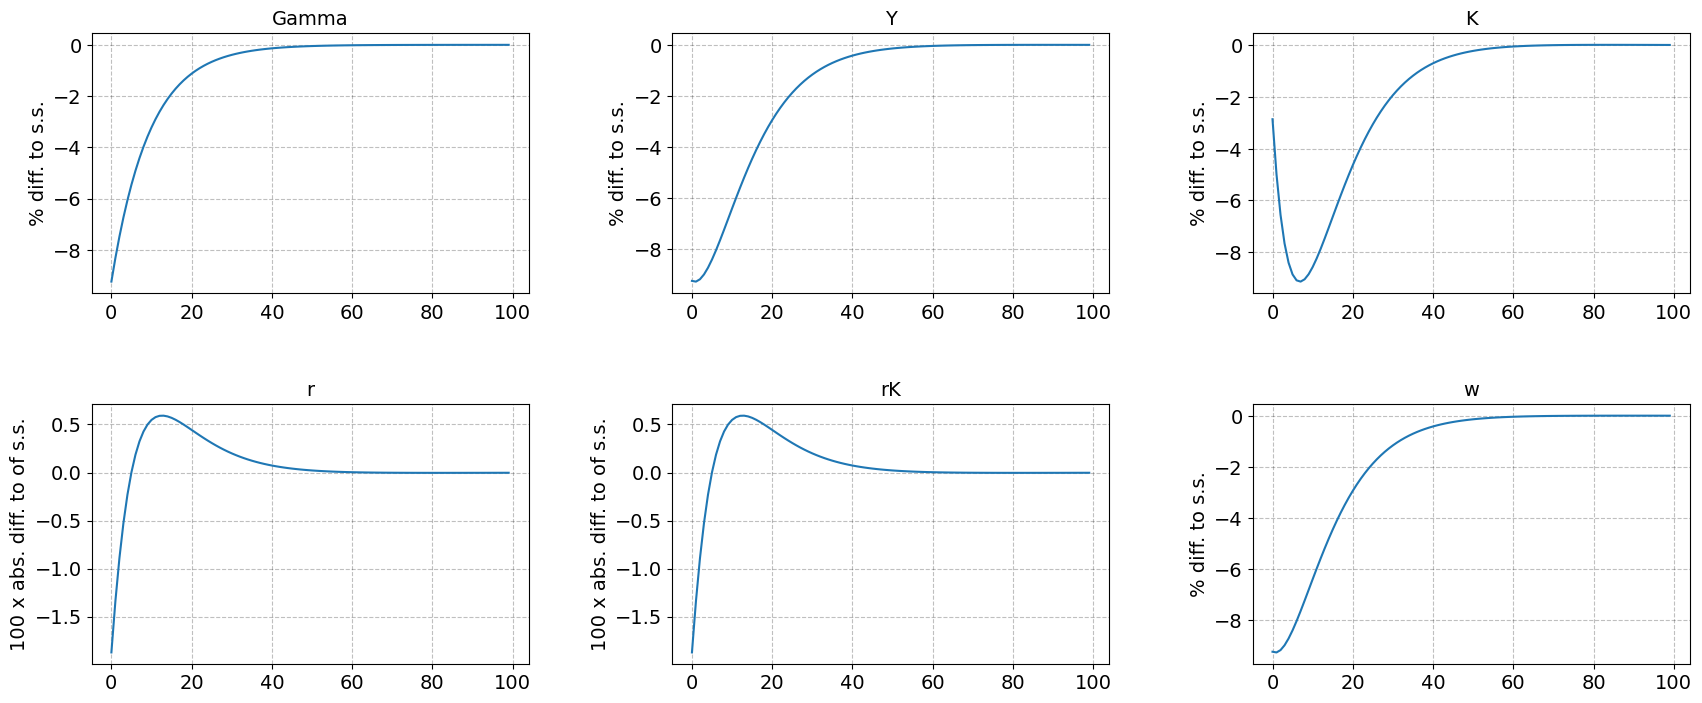


### tagets ###


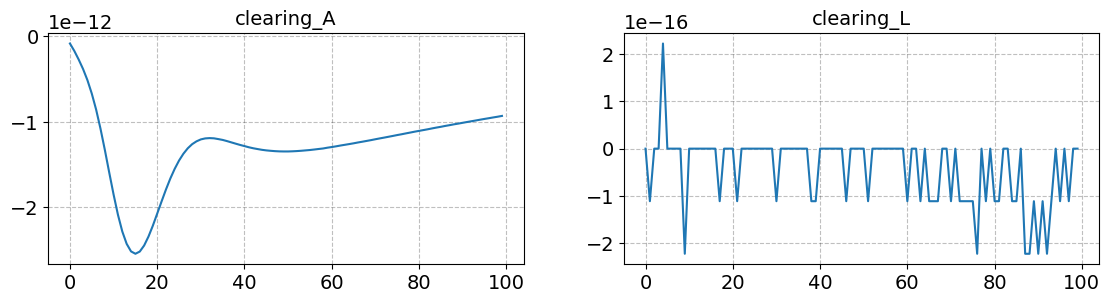

In [33]:
paths = ['Gamma','Y','K','r','rK','w']
abs_diff = ['r','rK']
facs = {'r':100,'rK':100}
model.show_IRFs(paths,abs_diff=abs_diff,facs=facs,ncols=3,T_max=100,filename='figs/technology_shock')

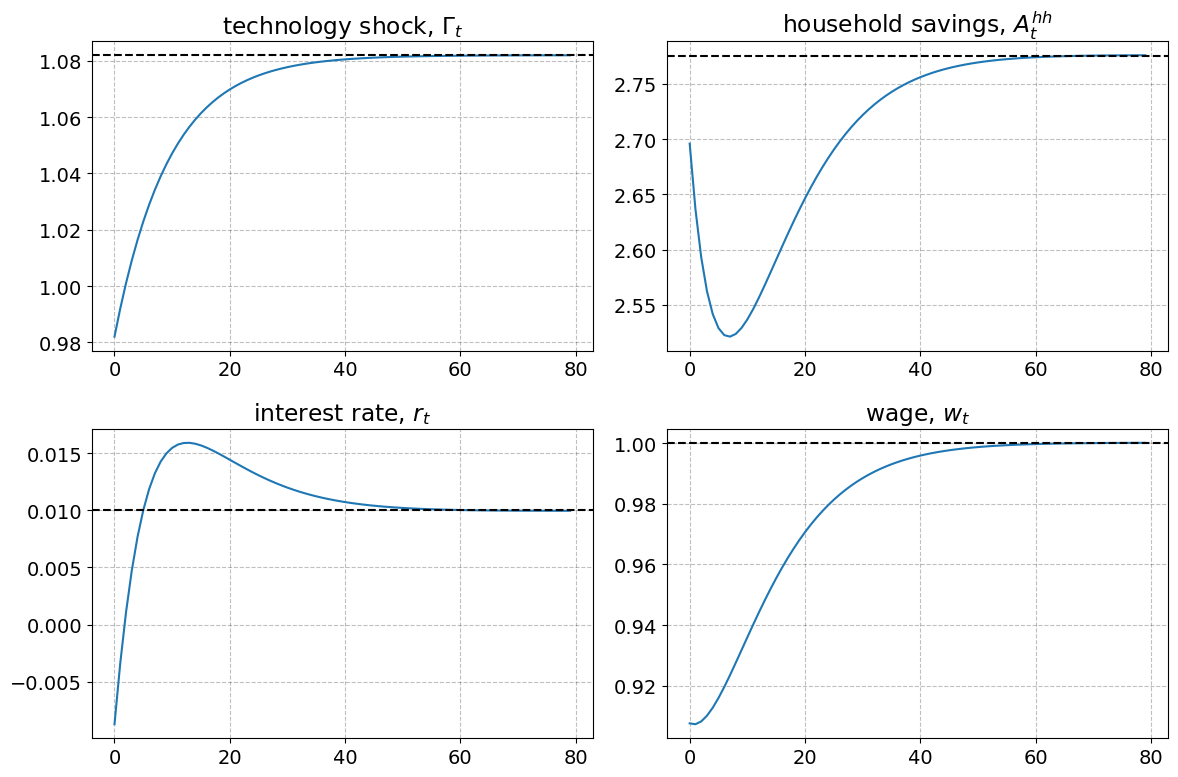

In [35]:
T_max = 80

fig = plt.figure(figsize=(12,2*4),dpi=100)

ax = fig.add_subplot(2,2,1)
ax.plot(np.arange(T_max),path.Gamma[:T_max])
ax.axhline(ss.Gamma,color='black',linestyle='--')
ax.set_title('technology shock, $\Gamma_t$')

ax = fig.add_subplot(2,2,2)
ax.plot(np.arange(T_max),path.A_hh[:T_max])
ax.axhline(ss.A_hh,color='black',linestyle='--')
ax.set_title('household savings, $A^{hh}_t$')

ax = fig.add_subplot(2,2,3)
ax.plot(np.arange(T_max),path.r[:T_max])
ax.axhline(ss.r,color='black',linestyle='--')
ax.set_title('interest rate, $r_t$')

ax = fig.add_subplot(2,2,4)
ax.plot(np.arange(T_max),path.w[:T_max])
ax.axhline(ss.w,color='black',linestyle='--')
ax.set_title('wage, $w_t$')

fig.tight_layout()
fig.savefig('figs/transition_path.pdf')

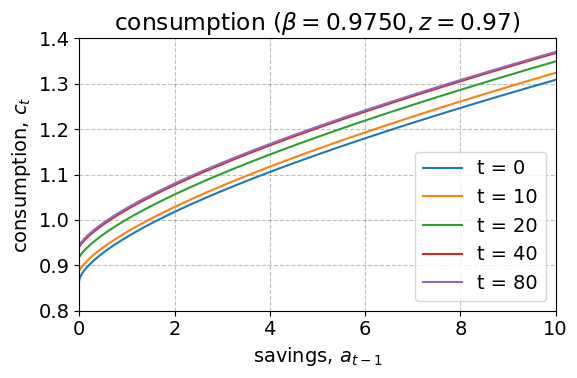

In [15]:
i_beta = 1
i_z = par.Nz//2
beta = par.beta_grid[i_beta]
z = par.z_grid[i_z]

fig = plt.figure(figsize=(6,4),dpi=100)

I = par.a_grid < 500

# a. consumption
ax = fig.add_subplot(1,1,1)
ax.set_title(f'consumption ($\\beta = {beta:.4f}, z = {beta:.2f}$)')

ts = [0,10,20,40,80]
for t in ts:
    ax.plot(par.a_grid[I],path.c[t,i_beta,i_z,I],label=f'{t = }')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')
ax.set_xlim(0,10)
ax.set_ylim(0.8,1.4)

fig.tight_layout()
fig.savefig('figs/c_func_path.pdf')

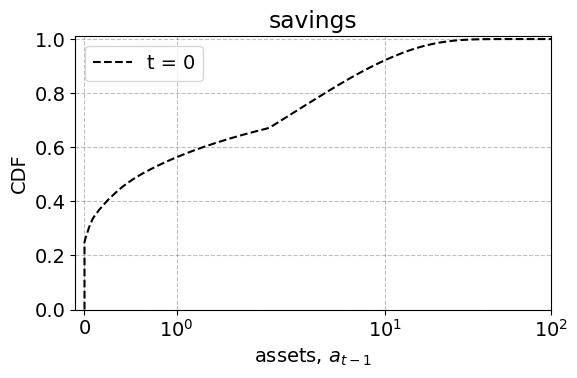

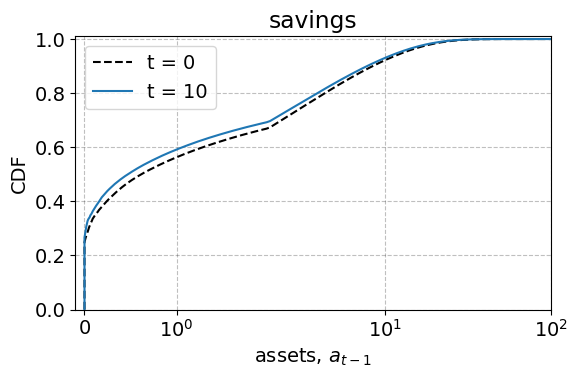

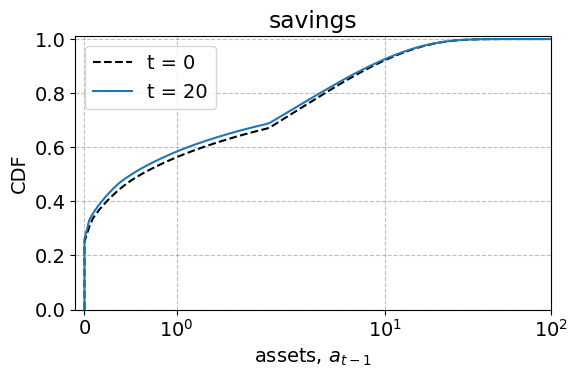

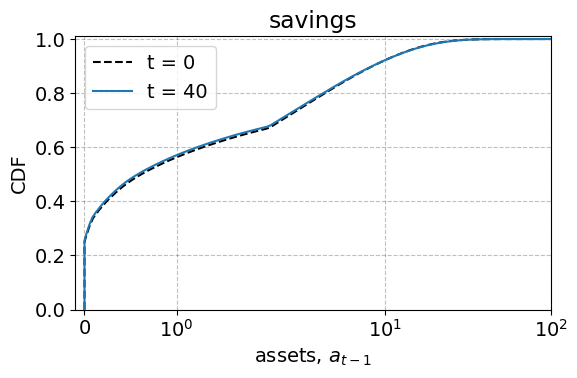

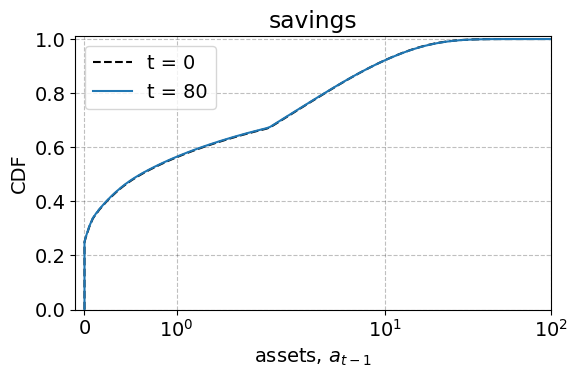

In [36]:
for t in ts:

    fig = plt.figure(figsize=(6,4),dpi=100)

    ax = fig.add_subplot(1,1,1)
    ax.set_title('savings')    

    ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),np.insert(np.cumsum(np.sum(path.D[0],axis=(0,1))),0,0.0),label=f't = 0',ls='--',color='black')
    
    if not t == 0:
        ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),np.insert(np.cumsum(np.sum(path.D[t],axis=(0,1))),0,0.0),label=f't = {t}')

    ax.set_xlabel('assets, $a_{t-1}$')
    ax.set_ylabel('CDF')
    ax.set_xscale('symlog')
    ax.legend()
    ax.set_xlim([-0.1,100])
    ax.set_ylim([0,1.01])

    fig.tight_layout()
    fig.savefig(f'figs/distribution_path_{t}.pdf')

## 6. <a id='toc6_'></a>[Decompose household behavior](#toc0_)

Find behavior when only some household inputs are active.

['r']
household problem solved along transition path in 0.4 secs
household problem simulated along transition in 0.2 secs

['w']
household problem solved along transition path in 0.4 secs
household problem simulated along transition in 0.2 secs

all
household problem solved along transition path in 0.4 secs
household problem simulated along transition in 0.1 secs



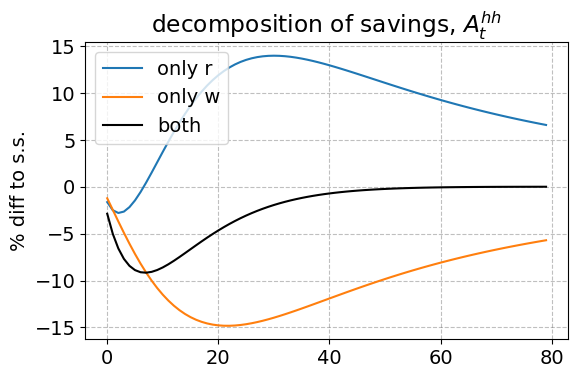

In [17]:
T_max = 80

fig = plt.figure(figsize=(6,4),dpi=100)
ax = fig.add_subplot(1,1,1)
    
i_color = 0
for use_inputs in [['r'],['w'],'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=True,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'both'
        ls = '-'
        color = 'black'
    else:
        label = f'only {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.A_hh[:T_max]/ss.A_hh-1)*100,ls=ls,color=color,label=label);

ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True)
ax.set_title('decomposition of savings, $A^{hh}_t$')

fig.tight_layout()
fig.savefig('figs/decomposition.pdf')

**Case 2:** Behavior for a subset of households. Here those with zero assets.

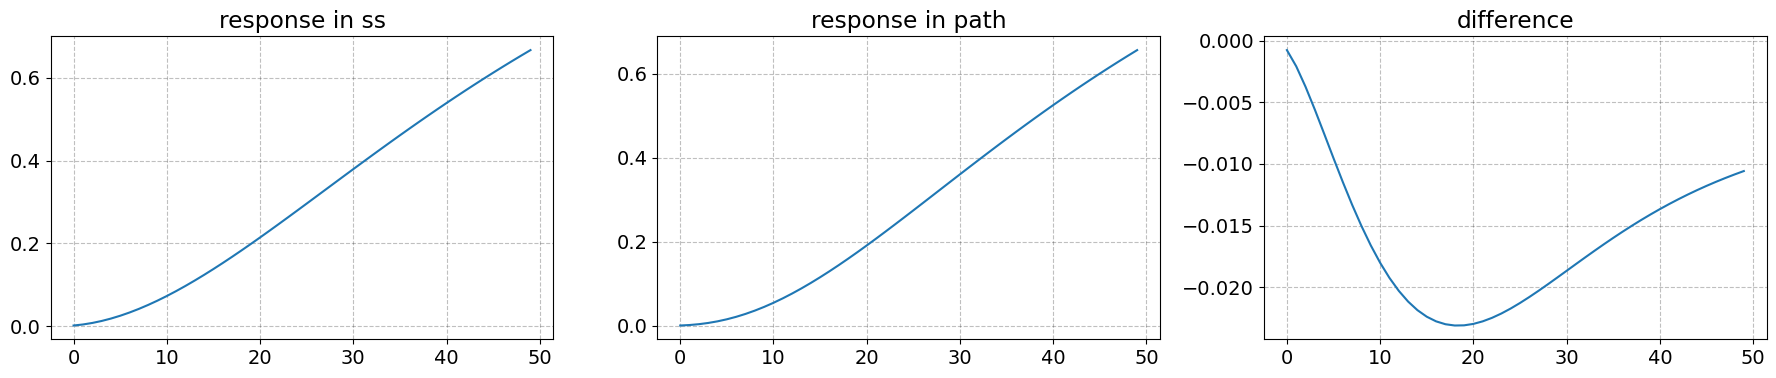

In [18]:
T_max = 50

fig = plt.figure(figsize=(3*6,4),dpi=100)
    
Dbeg = ss.Dbeg.copy()
Dbeg[:,:,1:] = 0.0 # zero every else than in first asset grid point
Dbeg /= np.sum(Dbeg) # re-normalize

path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
path_alt = model.decompose_hh_path(Dbeg=Dbeg,use_inputs='all') 

ax = fig.add_subplot(1,3,1)
ax.set_title('response in ss')
ax.plot(path_alt_ss.A_hh[:T_max]);

ax = fig.add_subplot(1,3,2)
ax.set_title('response in path')
ax.plot(path_alt.A_hh[:T_max]);

ax = fig.add_subplot(1,3,3)
ax.set_title('difference')
ax.plot(path_alt.A_hh[:T_max]-path_alt_ss.A_hh[:T_max])

fig.tight_layout()

## 7. <a id='toc7_'></a>[Custom shocks](#toc0_)

### 7.1. <a id='toc7_1_'></a>[Path](#toc0_)

In [19]:
# a. define shock
dGamma = np.zeros(par.T)
dGamma[12:24] = 0.01*ss.Gamma
shocks = {'dGamma':dGamma} # note the 'd' for difference (in absolute terms)

# b. find transition path
model.find_transition_path(do_print=True,shocks=shocks)

finding the transition path:
 it =   0 -> max. abs. error = 1.65e-01
   1.65e-01 in clearing_A
   2.59e-14 in clearing_L
 it =   1 -> max. abs. error = 2.45e-03
   2.45e-03 in clearing_A
   4.44e-16 in clearing_L
 it =   2 -> max. abs. error = 5.97e-05
   5.97e-05 in clearing_A
   7.77e-16 in clearing_L
 it =   3 -> max. abs. error = 2.77e-07
   2.77e-07 in clearing_A
   8.88e-16 in clearing_L
 it =   4 -> max. abs. error = 2.74e-09
   2.74e-09 in clearing_A
   6.66e-16 in clearing_L
 it =   5 -> max. abs. error = 6.95e-12
   6.95e-12 in clearing_A
   4.44e-16 in clearing_L

transition path found in 5.4 secs


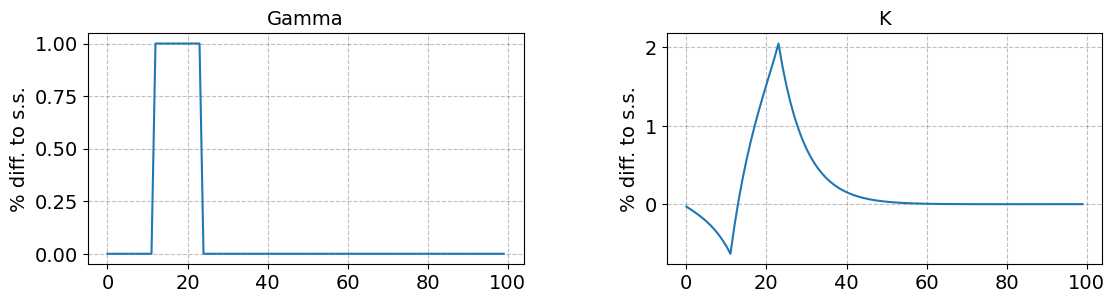

In [20]:
model.show_IRFs(['Gamma','K'],T_max=100,do_shocks=False,do_targets=False,ncols=2,filename='figs/future_technology_shock')

### 7.2. <a id='toc7_2_'></a>[Initial distribution](#toc0_)

**Shock:** Assume everybody looses 5 percent of their wealth.

In [21]:
K_shock = -0.05

**Adjust distribution:**

In [22]:
ini = {}
ini['Dbeg'] = np.zeros(ss.Dbeg.shape)
for i_a_lag in range(par.Na):
    
    # a. assets after shock
    a_lag = par.a_grid[i_a_lag]
    a_lag_after = a_lag*(1+K_shock)
    
    # b. new grid point
    for i in range(par.Na-1):
        if not par.a_grid[i+1] <= a_lag_after: break
    
    # c. distribute mass
    w = (par.a_grid[i+1]-a_lag_after)/(par.a_grid[i+1]-par.a_grid[i])
    
    for i_fix in range(par.Nfix):
        ini['Dbeg'][i_fix,:,i] += w*ss.Dbeg[i_fix,:,i_a_lag]
        ini['Dbeg'][i_fix,:,i+1] += (1-w)*ss.Dbeg[i_fix,:,i_a_lag]    
    

**Calculate new capital stock:**

In [23]:
ini_K = ini['K'] = np.sum(par.a_grid*ini['Dbeg'])
print(f'{ss.K  = :.3f}')
print(f'{ini_K = :.3f}')

ss.K  = 2.775
ini_K = 2.636


**Find transition with no shocks:**

In [24]:
model.find_transition_path(do_print=True,ini=ini,shocks=[]) 

finding the transition path:
 it =   0 -> max. abs. error = 1.33e-01
   1.33e-01 in clearing_A
   2.58e-14 in clearing_L
 it =   1 -> max. abs. error = 7.77e-04
   7.77e-04 in clearing_A
   4.44e-16 in clearing_L
 it =   2 -> max. abs. error = 1.12e-05
   1.12e-05 in clearing_A
   4.44e-16 in clearing_L
 it =   3 -> max. abs. error = 3.02e-08
   3.02e-08 in clearing_A
   3.33e-16 in clearing_L
 it =   4 -> max. abs. error = 2.31e-10
   2.31e-10 in clearing_A
   2.22e-16 in clearing_L
 it =   5 -> max. abs. error = 1.18e-13
   1.18e-13 in clearing_A
   7.77e-16 in clearing_L

transition path found in 4.8 secs


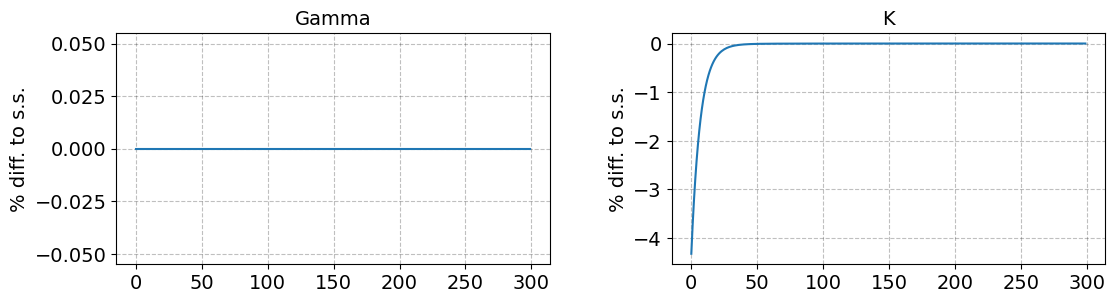

In [25]:
model.show_IRFs(['Gamma','K'],T_max=300,do_shocks=False,do_targets=False,ncols=2,filename='figs/initial_distribution')